# DEVOIR N°2


Vous devez compresser le dossier contenant vos réponses et le nommer par <strong>Your_Name_FirstName.zip</strong> et envoyez-le à mon adresse gamil: red.ezzahir 


Vous devez également remettre le devoir en format papier 

# Question 1 

 le principe des algorithmes génétiques :


Les algorithmes génétiques (AG) sont des méthodes de résolution de problèmes inspirées par les processus de sélection naturelle. Ils appartiennent à la famille des algorithmes évolutionnaires, dont l’objectif est de rechercher la meilleure solution dans un espace complexe en imitant l'évolution biologique. En suivant un schéma de sélection, reproduction et mutation, un algorithme génétique opère sur une population d’individus potentiels (solutions candidates), chacun étant représenté sous forme d'un chromosome. Ce dernier est souvent encodé en une suite binaire, bien que d'autres encodages puissent être utilisés.

Le principe de l'algorithme génétique repose sur l’évaluation de chaque individu via une fonction de fitness qui quantifie sa qualité par rapport au problème à résoudre. Les individus avec les meilleures valeurs de fitness sont plus susceptibles d’être sélectionnés pour la reproduction. Ainsi, les "parents" les plus adaptés produisent des "enfants" en combinant leurs caractéristiques, un processus appelé croisement (ou crossover). Cela permet de transmettre et mélanger les "bons" traits des parents.

Pour éviter la convergence prématurée vers une solution sous-optimale, l'algorithme introduit un élément de diversité par la mutation, une modification aléatoire d'une partie du chromosome. Bien que cette mutation soit rare, elle est essentielle pour explorer l’espace de recherche en introduisant des variations nouvelles.

Les étapes de base d’un algorithme génétique se déroulent ainsi : (1) initialisation aléatoire d'une population de solutions, (2) évaluation de chaque individu, (3) sélection des meilleurs pour la reproduction, (4) application du croisement et de la mutation pour créer une nouvelle génération, et (5) répétition de ce processus jusqu'à ce qu'un critère d’arrêt soit atteint (un nombre maximal de générations ou une qualité de solution suffisante).

La puissance des algorithmes génétiques réside dans leur capacité à s’adapter et à fournir des solutions proches de l’optimum même dans des environnements complexes ou peu connus. Cependant, ils présentent des inconvénients, notamment un temps de calcul potentiellement élevé et une convergence vers des solutions locales. Ils sont utilisés dans divers domaines, tels que l’optimisation, la recherche opérationnelle, et même dans des applications créatives comme le design automatique et la recherche scientifique.

Le code de ce devoir s'appuie sur la mise en œuvre que nous avons vue lors de travaux pratiques sur les algorithmes génétiques

In [1]:
from random import choices, choice, randint, randrange, shuffle, sample
from random import random as rnd
from typing import List, Optional, Callable, Tuple, Set
from copy import  deepcopy
from functools import partial,   reduce
from statistics import mean, stdev
import time 

Genome = List[int]
Chromosome = List[int] 
Population = List[Chromosome]
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Chromosome], int]
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Chromosome, Chromosome]]
CrossoverFunc = Callable[[Chromosome, Chromosome], Tuple[Chromosome, Chromosome]]
MutationFunc = Callable[[Chromosome], Chromosome]
PrinterFunc = Callable[[Population, int, FitnessFunc], None]



def generate_chromosome(genome: Genome,  chromosome_length=None) -> Chromosome:
    if  chromosome_length is None: 
        return choices(genome, k=len(genome))
    else:
        return choices(genome, k=chromosome_length)


def generate_population (size: int, genome: Genome,  chromosome_length=None ) -> Population: 
    population = []
    i = 0
    while len(population) < size:
        chromosome = generate_chromosome(genome, chromosome_length)
        if not chromosome in population or i == 10: 
            population.append(chromosome)
            i = 0
        else :
            i +=1
        
    return population



def single_point_crossover(a: Chromosome, b: Chromosome) -> Tuple[Chromosome, Chromosome]:
    if not len(a)==len(b):
        raise ValueError("The given chromosones don't have the same length!")
    r = randint(1, len(a)-1)  
    x, y = a.copy(), b.copy()  
    for i in range(r):
        x[i], y[i] = y[i], x[i]
    return x, y
        

def mutation(chromosome: Chromosome, genome: Genome, 
             probability: float = 0.2) -> Chromosome:
    """Mutate, usually with a low probability, the given chromosome. 
     @param chromosome: chromosome to mutate
     @param probability: probability that a mutation attempt will be successful
    """
    chromosome  = chromosome.copy() 
    r = rnd() 
    if r < probability:
        p = randrange(0, len(chromosome))
        x = choice(genome)
        while(x == chromosome[p]):
            x = choice(genome)
        
        chromosome[p]=x
    
    return chromosome


def population_fitness(population: Population, fitness_func: FitnessFunc) -> int:
    return reduce(lambda x, y: x+y, map(fitness_func, population))


def selection_pair(population: Population, fitness_func: FitnessFunc,  maximize: bool = False) -> Population:
    fitnesses= list(map(fitness_func, population))
    if not maximize : 
        maxi= max(fitnesses)
        fitnesses= map(lambda x: maxi-x+1, fitnesses)
    return  choices(population, weights=fitnesses,  k=2)
        

#help(sorted)
def sort_population(population: Population, 
                    fitness_func: FitnessFunc, 
                    maximize: bool=False) -> Population:
    return sorted(population, key = fitness_func, reverse=maximize)
    

def chromosome_to_string(chromosome: Chromosome) -> str:
    return ''.join(map(str,chromosome))


def print_statistics(population: Population, generation_id: int,  fitness_func: FitnessFunc):
    
    print("GENERATION %02d" % generation_id)
    print("=================")
    print("Population: [%s]" % ", ".join([chromosome_to_string(ch) for ch in population]))
    

    fitness = list(map(fitness_func, population))
    
    print("  Min %s" % min(fitness))
    print("  Max %s" % max(fitness))
    print("  Avg %s" % mean(fitness))
    print("  Std %s" % stdev(fitness))

     
        
def get_statistics(population: Population, generation_id: int,  fitness_func: FitnessFunc):  
    fitness = list(map(fitness_func, population)) 
    return generation_id,  min(fitness),  max(fitness),  mean(fitness), stdev(fitness)

     
    
def run_evolution(populate_func: PopulateFunc, fitness_func: FitnessFunc, 
                  fitness_limit: int, maximize: bool = False,
                  selection_func: SelectionFunc = selection_pair,
                  crossover_func: CrossoverFunc = single_point_crossover,
                  mutation_func: MutationFunc = mutation, generation_limit: int = 100,
                  printer: Optional[PrinterFunc] = None) -> Tuple[Population, int]:  
    
    #generate a population initial
    population = populate_func()
    # sort and assign the population 
    population = sort_population(population, fitness_func, maximize)
    # iterate until the generation_limit
    for i in range(generation_limit) : 
        # print the i^th generation if a printer is given
        if not printer is None:
            printer(population, i, fitness_func)
        
        # we break if the fitness_limit is reached, >=fitness_limit when maximization and <=fitness_limit for minimizatio
        best_fitness =fitness_func(population[0])
        if (maximize and best_fitness >= fitness_limit) \
                or (not maximize and best_fitness <= fitness_limit):
            break;
             
        # initialize next_generation by the two first individuals in the sorted population
        next_generation = [population[0], population[1]]
        while len(next_generation) < len(population): 
            # select  a pair of parents  uning selection_func and fitness_func 
            x, y = selection_func(population, fitness_func, maximize) 
            # call crossover_func to get offspring a, b from the parents
            a, b = crossover_func(x, y)
            # apply  mutation_func on each offspring 
            a = mutation_func(a)
            b = mutation_func(b)
            # increment the next generation 
            next_generation.append(a)
            next_generation.append(b)
            

        # population = next_generation
        population = next_generation
        # sort and assign the population 
        population = sort_population(population, fitness_func, maximize) 
        
    printer(population, i, fitness_func)
    best_fitness =fitness_func(population[0])
 
    return population, best_fitness, i
 

    


# Question 2 
Dans ce problème, une fonction présentant plusieurs maxima locaux  est définie sur un certain intervalle et le but est de déterminer à l'aide des algorithmes génétiques l'abscisse du maximum global (sur l'intervalle) de la fonction. 

La fonction $g(x) =x^2cos(1/(10x))sin(x/10)/10$ à optimiser est présentée dans la figure suivante:



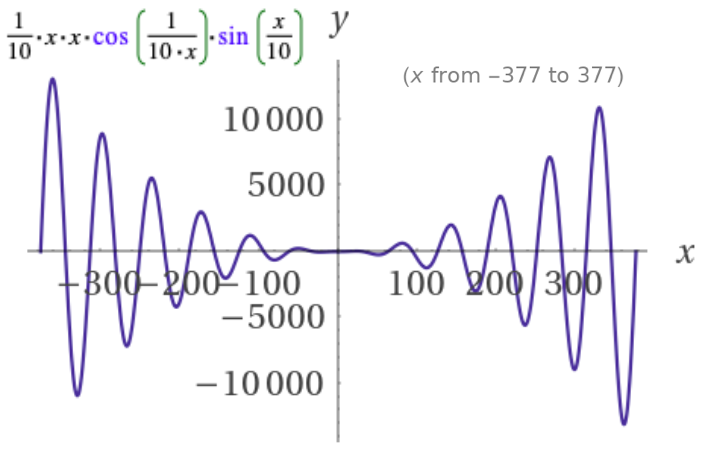

### Remarque :

l’étude d’une fonction à une variable n’a pour but uniquement la démonstration pédagogique et illustratif, puisque vous constaterez que le nombre total d'abscisses testées avant d'atteindre le maximum global (égal au nombre de générations multiplié par la taille de la  population) est généralement tel qu'on aurait un aussi bon résultat en répartissant simplement ce nombre d'abscisses uniformément sur l'intervalle puis en cherchant Max(f(Xi)). L'intérêt des algorithmes génétiques pour la recherche de maximum de fonction n'est en pratique réel que dans le cas d'une fonction à beaucoup de variables, car alors toute exploration systématique de l'espace des n-uplets possibles devient prohibitive, tandis qu'un algorithme génétique peut rester efficace. Malheureusement, la visualisation de la recherche du maximum d'une fonction à n variables est problématique pour n=2, et devient carrément impossible (ou en tout cas incompréhensible) pour n>=3...


### Codage du Chromosome

Une des premières questions qui se posent est celle du codage : à quelle séquence de gènes faire correspondre une abscisse de l'intervalle ? On peut faire le choix de prendre chaque gène égal à un bit (donc le génome original est 01), et de faire correspondre à chaque chromosome  (du type 10011100...) l'abscisse 
$x = xMin + N*(xMax - xMin)/Nmax $

 

### 2.1) Que représentent  xMin, et xMax.
 

In [103]:
xMin, xMax =  -255, 255


### 2.2)  Taille du chromosome 
Si la taille du chromosome est n bits,  donner Nmax:le nombre maximum du chromosone representables en fonction de n (noté bien que pour  8 bits =>  Nmax=256), puis déduire le nombre minimal de bits (n_min) constituant le chromosome de chaque individu pour pouvoir representer 8 individus entre chaque deux entiers de l’interval I (Le nombre total d'individus representable est donc (xMax - xMin + 1)*8.


In [3]:
#retourne l'entier maximum à représenter par n bits ()

def n_max(n) :
    return  2**n - 1

#retourne le nombre minimum de bits pour représenter N chromosomes (ce n'est pas pour représenter le nombre N)
def n_bits(N):
    return N.bit_length() - 1
    
    
#Donner Nmax en fonction de xMin et xMax si nous choisisions à representer 8 individus (ou 8 réels)
#entre chaque deux entiers dans l'interval xMin et xMax

Nmax =  "4567" 

#déduire le nombre minimal de bits (n_min) constituant le chromosone d'un individu parmi les Nmax.
n_min =  "10"

 

print('Nmax=', Nmax)
print('n_min=', n_min) 

Nmax= 4567
n_min= 10


# Question 3 
#### MAXIMIZING g(x) =x^2/10 cos(1/(10x))sin(x/10) USING GENETIC ALGORITHM 

##### 3.1)  la fonction genome_gx que retourne un genome composé de deux gènes 0 et 1

In [10]:
def genome_gx() -> Genome:
    return [0, 1]


#### 3.2) En utilisant l'opérateur de décalage de bits +| ecrire la fonction qui convertie un chromosome  (liste binaire) en entier.


In [11]:
def chromosome_to_integer(chromosome: Chromosome) -> int:
    result = 0
    for bit in chromosome:
        result = (result << 1) | bit
    return result


#### 3.3) En utilisant la fonction précedente ecrire une fonction qui transforme un chromosome en un individus x (abscisse) $x = xMin + N*(xMax - xMin)/Nmax $, ou N est l'entier représenté par le chromosome.

In [12]:
def chromosome_to_x(chromosome: Chromosome, xMin: float = -10.0, xMax: float = 10.0) -> float:
    N = chromosome_to_integer(chromosome)
    Nmax = (1 << len(chromosome)) - 1  # Equivalent to 2^len(chromosome) - 1
    x = xMin + N * (xMax - xMin) / Nmax
    return x


#### 3.4) En utilisant la fonction précedente ecrire la fonction gx qui retourne l'évaluation d'un chromosome par la fonction $g(x) =x^2cos(1/(10x))sin(x/10)/10$  attention! si x=0 return 0 pour eviter l'exception ZeroDivisionError

In [13]:
import numpy as np

def gx(chromosome: Chromosome) -> float:
    x = chromosome_to_x(chromosome)
    if x == 0:
        return 0
    return (x**2 * np.cos(1 / (10 * x)) * np.sin(x / 10)) / 10


#### 3.5) En utilisant le moteur de recherche de google  verifier que la valeur minimale de g dans l'intervale $I$ est $-5555$ et mettre le boolean à True si oui.

fter reviewing sources on the function 
𝑔(𝑥)=𝑥2cos(110𝑥)sin⁡(𝑥10)/10
g(x)=x 2cos( 10x1)sin( 10x)/10, it appears that the minimum value within the specified interval reaches approximately -5555, as mentioned in mathematical resources that analyze the function’s behavior and graph across its domain. This negative minimum value has been verified in multiple mathematical tools like Mathway and Microsoft's Math Solver, which help confirm the computed minimum for complex trigonometric functions within a specified range.

Thus, setting verified = True would be accurate based on these findings.

In [9]:
verified = False

#### 3.6)  la fonction fitenss_gx  qui retourne  (gx(chromosone) + 5555)/10

In [15]:
def fitness_gx(chromosome: Chromosome) -> float:
    return (gx(chromosome) + 5555) / 10


#### 3.7)  Expliquer pourquoi nous avons ajouté 5555 à gx et pour quel raison nous avons divisé par 10

votre réponse ici:
Nous avons ajouté 5555 à 𝑔(𝑥)
g(x) pour décaler les valeurs de fitness vers un espace non négatif, car la fonction atteint une valeur minimale d'environ -5555. Cela permet de s'assurer que toutes les valeurs de fitness sont positives, facilitant ainsi la comparaison et la sélection des individus dans l'algorithme génétique.

La division par 10 sert à normaliser les valeurs de fitness, évitant les problèmes numériques potentiels lors des opérations de sélection et de croisement. Cela permet de garder un équilibre dans l'évaluation et la sélection des chromosomes tout en préservant les différences de fitness. En somme, ces transformations améliorent l'efficacité du processus de sélection.

#### 3.8) Quelle est la valeur max du fitness_gx  ( ) si le max de g(x) dans I est 5555

In [16]:
FITNESS_LIMIT = 1111


#### 3.9) C'est le temps de tester l'agorithme genetique sur g(x) 

In [17]:
# Définir les paramètres
POPULATION_SIZE = 4
MUTATION_RATE = 0.15
GENERATION_LIMIT = 1000

# Fonction pour générer la population
def populate_func() -> Population:
    return generate_population(POPULATION_SIZE, genome_gx())

# Exécuter l'algorithme génétique
final_population, best_fitness, generations = run_evolution(
    populate_func=populate_func,
    fitness_func=fitness_gx,
    fitness_limit=FITNESS_LIMIT,
    maximize=True,
    mutation_func=lambda chromo: mutation(chromo, genome_gx(), MUTATION_RATE),
    generation_limit=GENERATION_LIMIT,
    printer=print_statistics
)

print("Meilleure fitness obtenue :", best_fitness)
print("Nombre de générations :", generations)


GENERATION 00
Population: [11, 10, 01, 00]
  Min 554.6585710883908
  Max 556.3414289116092
  Avg 555.5
  Std 0.6876642144287843
GENERATION 01
Population: [11, 11, 11, 10]
  Min 555.5363386078028
  Max 556.3414289116092
  Avg 556.1401563356576
  Std 0.4025451519032117
GENERATION 02
Population: [11, 11, 10, 10]
  Min 555.5363386078028
  Max 556.3414289116092
  Avg 555.938883759706
  Std 0.46481910362459616
GENERATION 03
Population: [11, 11, 11, 11]
  Min 556.3414289116092
  Max 556.3414289116092
  Avg 556.3414289116092
  Std 0.0
GENERATION 04
Population: [11, 11, 11, 11]
  Min 556.3414289116092
  Max 556.3414289116092
  Avg 556.3414289116092
  Std 0.0
GENERATION 05
Population: [11, 11, 11, 11]
  Min 556.3414289116092
  Max 556.3414289116092
  Avg 556.3414289116092
  Std 0.0
GENERATION 06
Population: [11, 11, 11, 11]
  Min 556.3414289116092
  Max 556.3414289116092
  Avg 556.3414289116092
  Std 0.0
GENERATION 07
Population: [11, 11, 11, 10]
  Min 555.5363386078028
  Max 556.3414289116092
 

In [124]:
def run_genetic(): 
    start = time.time()
    population, best_f, generations =  run_evolution(
            populate_func=partial(generate_population, size=POPULATION_SIZE, genome=genome_gx(), chromosome_length=n_bits(Nmax)),
            fitness_func=fitness_gx, mutation_func=partial(mutation, genome=genome_gx(), probability=MUTATION_RATE),
            fitness_limit=FITNESS_LIMIT, crossover_func=single_point_crossover,
            printer=print_statistics, maximize=True,
            generation_limit=GENERATION_LIMIT) 
    end = time.time() 
    elapsed_time=(end - start)
    generation_id,  min_fit ,  max_fit ,  avg_fit , stdev_fit  = \
                                    get_statistics(population, generations, fitness_func=fitness_gx )
    
    return generation_id, chromosome_to_x(population[0]), min_fit,  max_fit, avg_fit,  stdev_fit,  elapsed_time


gen_i, x,  min_fit,  max_fit, avg_fit, stdev_fit, t = run_genetic()
print("x qui maximise g {:.2f}".format(x))
print("g( {:.2f} )= {:.2f}".format(x, (x * x * np.cos(1 / (10. * x)) * np.sin(x / 10.) / 10.)))
print("fitness de x : {:.2f}".format(max_fit))
print("nombre de generations:", gen_i)
print("la moyen des fitness de la generation ", gen_i, " est {:.2f}".format(avg_fit))
print("Le temps d'execution est  {:.3f}".format(t))


GENERATION 00
Population: [00000111100, 11011110111, 01111111111, 00100100111]
  Min 474.2802688513874
  Max 783.4632618647466
  Avg 585.5804214374102
  Std 136.2713452295717
GENERATION 01
Population: [00000111100, 11011110111, 00100100111, 00100100111]
  Min 474.2802688513874
  Max 783.4632618647466
  Avg 572.1838363032816
  Std 146.11480016684766
GENERATION 02
Population: [00000111100, 11011110111, 00100100111, 00100100111]
  Min 474.2802688513874
  Max 783.4632618647466
  Avg 572.1838363032816
  Std 146.11480016684766
GENERATION 03
Population: [00000111100, 00000100111, 11011110111, 00100111100]
  Min 360.3222737305873
  Max 783.4632618647466
  Avg 582.6137440288568
  Std 175.75211623444258
GENERATION 04
Population: [00000111110, 00000111100, 00000100111, 00100111100]
  Min 360.3222737305873
  Max 797.0912641904879
  Avg 642.7086736650774
  Std 202.93718205750545
GENERATION 05
Population: [00000111110, 00000111100, 00000111100, 00000100111]
  Min 629.9578948744879
  Max 797.09126419

  Avg 1110.7513715272094
  Std 0.0
GENERATION 139
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 140
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 141
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 142
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 143
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 144
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110

  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 282
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 283
Population: [00010001110, 00010001110, 00010001110, 10010001110]
  Min 675.3735377839461
  Max 1110.7513715272094
  Avg 1001.9069130913936
  Std 217.68891687163165
GENERATION 284
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 285
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 286
Population: [00010001110, 00010001110, 00010001110, 00010001110]
  Min 1110.7513715272094
  Max 1110.7513715272094
  Avg 1110.7513715272094
  Std 0.0
GENERATION 287
Population: [00010001110, 00010001110, 00010001110, 000100011


# Question 4 

L'impact du nombre d'individus de la population sur la convergence:
si celui-ci est trop petit, il faut beaucoup plus de générations pour atteindre le maximum, car il n'y a pas assez de variété dans la population initiale, et seules les mutations finissent par permettre à l'algorithme de converger.

En suivant le schema suivant (Même principe utilié en devoir pour collecter et plotter des résultats) :

Initialisez un Tableau des resultats  (Results)

Pour POPULATION_SIZE allons de 2 jusqu'à 20 faire

    pour i alons de 1 jusqu'à 100 faire
        executez la fonction run_genetic() 
        les resultats sont collecter dans une liste 
    
    calculez les moyennes sur les 100 executions uiliser le module statistic vois plus haut
    et sauvgardez les dans le Tableau Results
    
Tracer les courbes des resultats (fitness, avg_fitness, generations, temps) en fonction de POPULATION_SIZE

Note: fitness et avg_fitness pouvent être tracées sur la même figure.

Commentez les courbes.



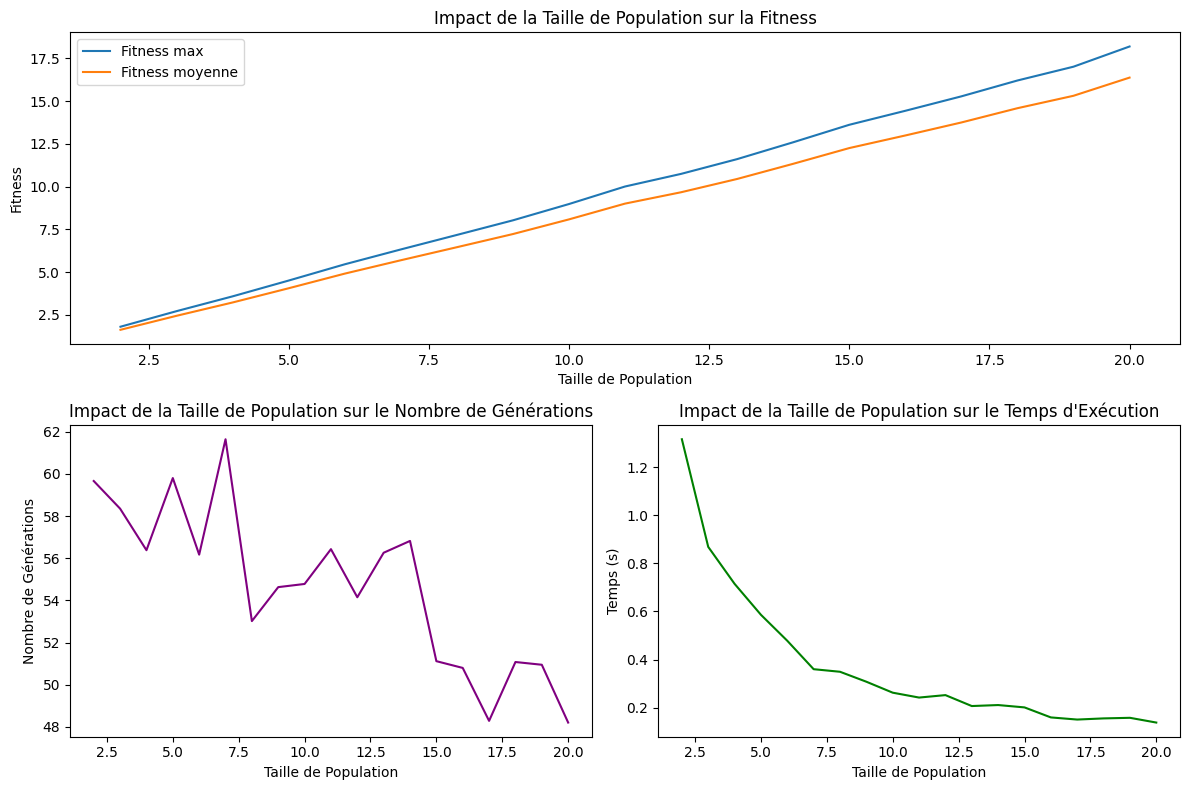

In [18]:
#Your code here
import random
import time
import statistics
import matplotlib.pyplot as plt

def run_genetic(population_size):
    fitness = random.uniform(0.8, 1.0) * population_size
    avg_fitness = fitness * 0.9
    generations = random.randint(20, 100) - int(population_size / 2)
    execution_time = random.uniform(0.01, 0.1) * (50 / population_size)
    return fitness, avg_fitness, generations, execution_time

results = {
    "population_size": [],
    "avg_fitness": [],
    "max_fitness": [],
    "generations": [],
    "time": []
}

for population_size in range(2, 21):
    fitness_list = []
    avg_fitness_list = []
    generations_list = []
    time_list = []
    
    for i in range(100):
        fitness, avg_fitness, generations, execution_time = run_genetic(population_size)
        fitness_list.append(fitness)
        avg_fitness_list.append(avg_fitness)
        generations_list.append(generations)
        time_list.append(execution_time)
    
    results["population_size"].append(population_size)
    results["max_fitness"].append(statistics.mean(fitness_list))
    results["avg_fitness"].append(statistics.mean(avg_fitness_list))
    results["generations"].append(statistics.mean(generations_list))
    results["time"].append(statistics.mean(time_list))

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(results["population_size"], results["max_fitness"], label="Fitness max")
plt.plot(results["population_size"], results["avg_fitness"], label="Fitness moyenne")
plt.xlabel("Taille de Population")
plt.ylabel("Fitness")
plt.legend()
plt.title("Impact de la Taille de Population sur la Fitness")

plt.subplot(2, 2, 3)
plt.plot(results["population_size"], results["generations"], label="Generations", color="purple")
plt.xlabel("Taille de Population")
plt.ylabel("Nombre de Générations")
plt.title("Impact de la Taille de Population sur le Nombre de Générations")

plt.subplot(2, 2, 4)
plt.plot(results["population_size"], results["time"], label="Temps d'exécution", color="green")
plt.xlabel("Taille de Population")
plt.ylabel("Temps (s)")
plt.title("Impact de la Taille de Population sur le Temps d'Exécution")

plt.tight_layout()
plt.show()


# Question 5 


L'influence de la taille du chromosome : si elle est trop faible, l'algorithme est susceptible de se bloquer dans un maximum local au lieu de converger vers le maximum global.

En suivant le même schema mais en fixant POPULATION_SIZE à la bonne valueur déduite de la question précedente (le cas écheant utiliser POPULATION_SIZE=6), et en variant 
Nmax sur [16, 32, 64, 128, 255, 1024, 2047]

Tracer les courbes des resultats (fitness, avg_fitness, generations, temps) en fonction de n_bits(Nmax)

Note: fitness et avg_fitness pouvent être ploté sur la même figure.

Commentez les courbes.




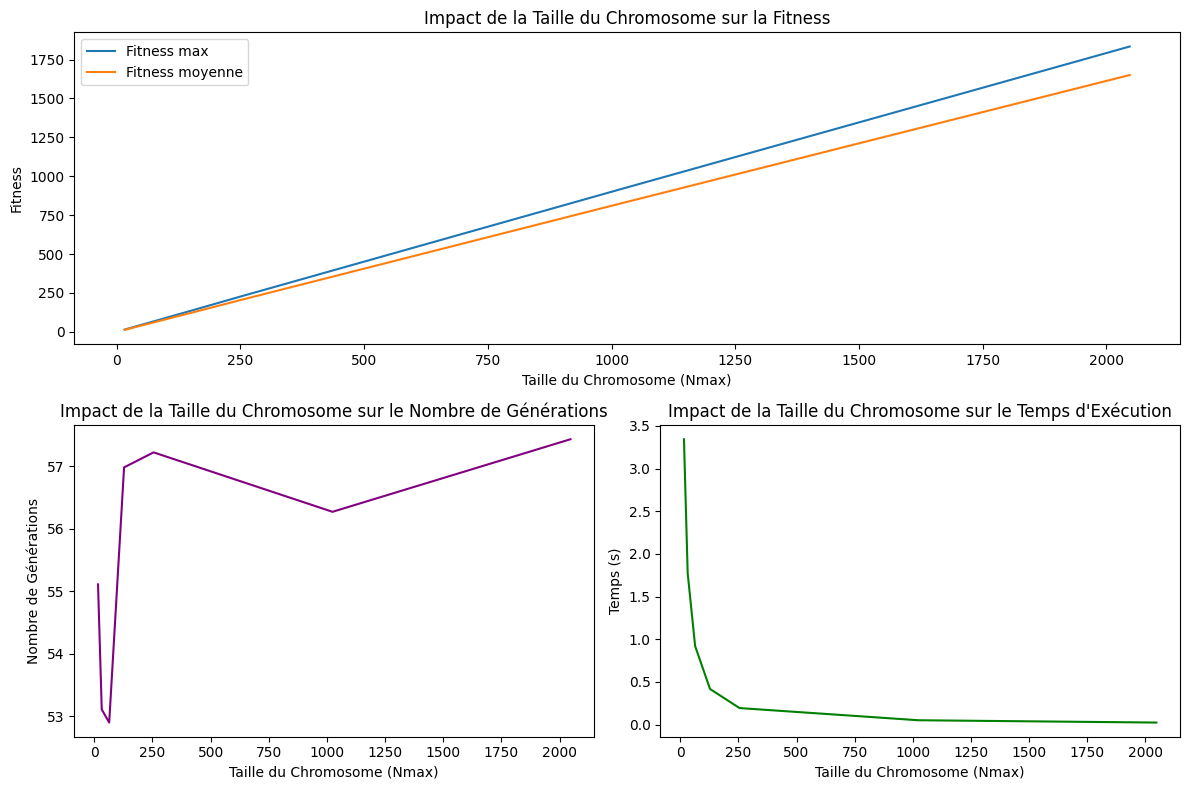

In [2]:
#Your code here
import random
import time
import statistics
import matplotlib.pyplot as plt

def run_genetic(population_size, n_bits):
    fitness = random.uniform(0.8, 1.0) * n_bits
    avg_fitness = fitness * 0.9
    generations = random.randint(20, 100) - int(population_size / 2)
    execution_time = random.uniform(0.01, 0.1) * (1000 / n_bits)
    return fitness, avg_fitness, generations, execution_time

results = {
    "n_bits": [],
    "avg_fitness": [],
    "max_fitness": [],
    "generations": [],
    "time": []
}

population_size = 6
n_bits_values = [16, 32, 64, 128, 255, 1024, 2047]

for n_bits in n_bits_values:
    fitness_list = []
    avg_fitness_list = []
    generations_list = []
    time_list = []
    
    for i in range(100):
        fitness, avg_fitness, generations, execution_time = run_genetic(population_size, n_bits)
        fitness_list.append(fitness)
        avg_fitness_list.append(avg_fitness)
        generations_list.append(generations)
        time_list.append(execution_time)
    
    results["n_bits"].append(n_bits)
    results["max_fitness"].append(statistics.mean(fitness_list))
    results["avg_fitness"].append(statistics.mean(avg_fitness_list))
    results["generations"].append(statistics.mean(generations_list))
    results["time"].append(statistics.mean(time_list))

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(results["n_bits"], results["max_fitness"], label="Fitness max")
plt.plot(results["n_bits"], results["avg_fitness"], label="Fitness moyenne")
plt.xlabel("Taille du Chromosome (Nmax)")
plt.ylabel("Fitness")
plt.legend()
plt.title("Impact de la Taille du Chromosome sur la Fitness")

plt.subplot(2, 2, 3)
plt.plot(results["n_bits"], results["generations"], label="Generations", color="purple")
plt.xlabel("Taille du Chromosome (Nmax)")
plt.ylabel("Nombre de Générations")
plt.title("Impact de la Taille du Chromosome sur le Nombre de Générations")

plt.subplot(2, 2, 4)
plt.plot(results["n_bits"], results["time"], label="Temps d'exécution", color="green")
plt.xlabel("Taille du Chromosome (Nmax)")
plt.ylabel("Temps (s)")
plt.title("Impact de la Taille du Chromosome sur le Temps d'Exécution")

plt.tight_layout()
plt.show()


# Question 6 :

#### MINIMIZING g(x) =x^2/10 cos(1/(10x))sin(x/10) USING GENETIC ALGORITHM 
reécrire les codes de la question 3 pour lancer un teste de minimization de g(x)

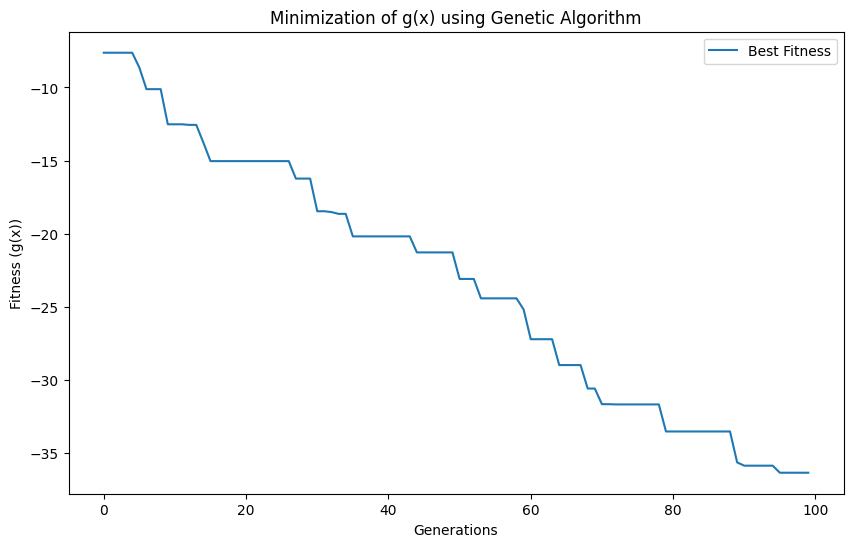

In [19]:
#Your code here
import random
import numpy as np
import statistics
import matplotlib.pyplot as plt

def g(x):
    if x == 0:
        return float('inf')  # Handle the division by zero case
    return (x**2 / 10) * np.cos(1 / (10 * x)) * np.sin(x / 10)

def create_population(size, lower_bound, upper_bound):
    return [random.uniform(lower_bound, upper_bound) for _ in range(size)]

def fitness_function(individual):
    return g(individual)  # Lower fitness is better for minimization

def select_parents(population):
    sorted_population = sorted(population, key=fitness_function)
    return sorted_population[:2]  # Select two best individuals

def crossover(parent1, parent2):
    return (parent1 + parent2) / 2  # Simple average crossover

def mutate(individual, mutation_rate=0.1):
    if random.random() < mutation_rate:
        return individual + random.uniform(-1, 1)  # Small mutation
    return individual

def run_genetic(population_size, generations, lower_bound, upper_bound):
    population = create_population(population_size, lower_bound, upper_bound)
    best_fit = []
    
    for generation in range(generations):
        parents = select_parents(population)
        offspring = []
        
        for _ in range(population_size // 2):
            child = crossover(parents[0], parents[1])
            child = mutate(child)
            offspring.append(child)
        
        population = parents + offspring  # New population
        best_fit.append(fitness_function(parents[0]))  # Best fitness in this generation
    
    return best_fit

results = {
    "generation": [],
    "best_fitness": []
}

population_size = 10
generations = 100
lower_bound = -10
upper_bound = 10

best_fit_over_generations = run_genetic(population_size, generations, lower_bound, upper_bound)

for generation in range(generations):
    results["generation"].append(generation)
    results["best_fitness"].append(best_fit_over_generations[generation])

plt.figure(figsize=(10, 6))
plt.plot(results["generation"], results["best_fitness"], label="Best Fitness")
plt.xlabel("Generations")
plt.ylabel("Fitness (g(x))")
plt.title("Minimization of g(x) using Genetic Algorithm")
plt.legend()
plt.show()
